## Задача 3.3

Предложить метод выбора наиболее важных признаков для логистической регрессии на основе изученных методов прикладной статистики. Осуществить выбор.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.feature_selection import chi2
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import itertools

Датасет достаточно известен, поэтому вопспользуемся возможностями библиотеки sklearn:

In [3]:
data = load_wine()
X, y, feature_names = data['data'], data['target'], data['feature_names']

df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

Логистическая регрессия - линейная модель, поэтому логично будет попробовать выявить, какие признаки наиболее сильно коррелированы с target-ом. Для этого воспользуемся корреляцией Пирсона:

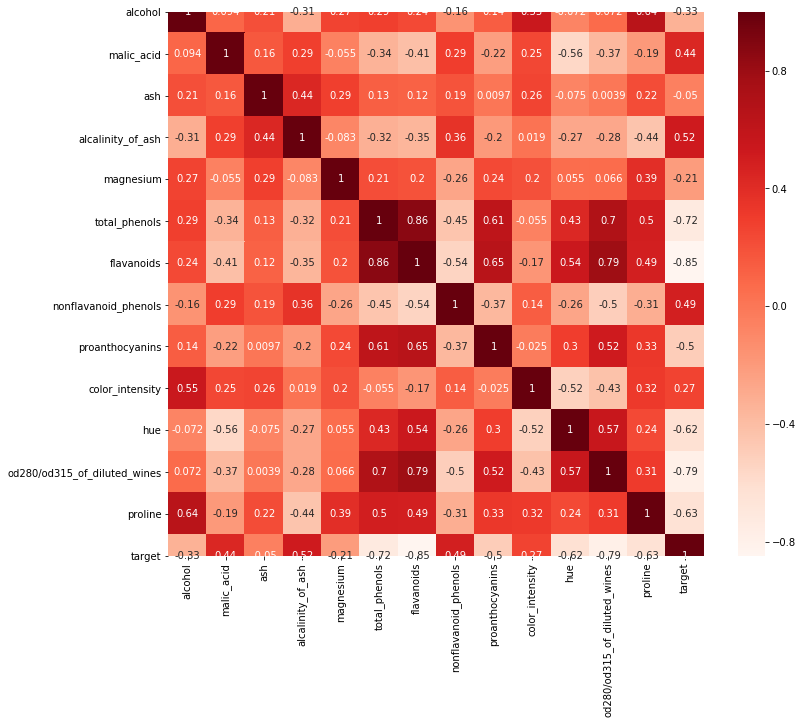

In [4]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Из heatmap видно, что наиболее коррелированными с target признаками являются flavanoids, od280/od314, total_phenols и, немного менее, proline и hue. Избавимся от остальных:

In [5]:
df.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'target'],
      dtype='object')

In [6]:
df_filtered = df.loc[:, ["flavanoids", "od280/od315_of_diluted_wines", 
                         "total_phenols", "proline", "hue", "target"]]

Однако не стоит забывать, что сильно коррелированные между собой признаки не отражаются хорошо на качестве модели, так что посмотрим ещё раз на корреляцию:

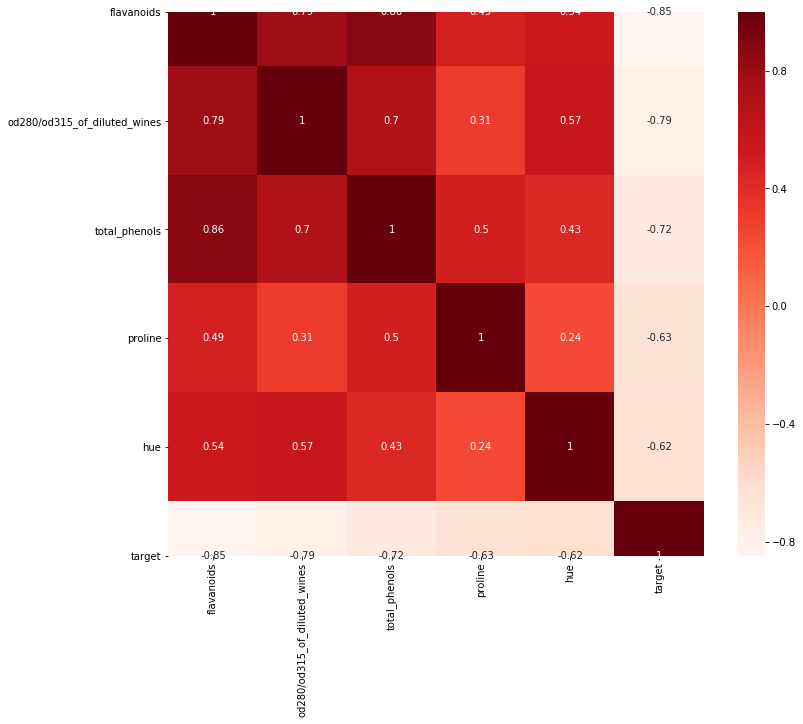

In [7]:
plt.figure(figsize=(12,10))
cor = df_filtered.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Как видно, total_phenols и flavanoids очень сильно коррелируют между собой. Возможно, мы сможем получить лучшие результаты, если удалим total_phenols, но сперва попробуем обучить модель на этих признаках и сравнить с baseline-ом:

In [30]:
lr = LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
lr.fit(X, y)

/Users/vinnibuh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
feat_1 = pd.DataFrame(lr.coef_[0].T).T
feat_1.columns = feature_names
feat_2 = pd.DataFrame(lr.coef_[1].T).T
feat_2.columns = feature_names
feat_3 = pd.DataFrame(lr.coef_[2].T).T
feat_3.columns = feature_names
pd.concat((feat_1, feat_2, feat_3)).reset_index(drop=True).T

,0,1,2
alcohol,-0.484600,1.032948,-0.038710
malic_acid,0.679153,-1.241981,0.431600
ash,1.258114,-0.270187,0.000000
alcalinity_of_ash,-0.626670,0.231305,0.048355
magnesium,-0.035765,0.004899,0.005481
total_phenols,0.000000,0.000000,0.000000
flavanoids,1.569371,0.664168,-3.518447
nonflavanoid_phenols,0.000000,0.000000,0.000000
proanthocyanins,0.000000,0.684689,0.000000
color_intensity,-0.023454,-2.036179,1.043890


Модель выбрала признаки с положительной корреляцией с таргетом. Попробуем обучить с предобработкой:

In [32]:
lr = LogisticRegression(penalty='l1', random_state=16, solver='liblinear')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr.fit(X_scaled, y)

/Users/vinnibuh/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=16, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
feat_1 = pd.DataFrame(lr.coef_[0].T).T
feat_1.columns = feature_names
feat_2 = pd.DataFrame(lr.coef_[1].T).T
feat_2.columns = feature_names
feat_3 = pd.DataFrame(lr.coef_[2].T).T
feat_3.columns = feature_names
pd.concat((feat_1, feat_2, feat_3)).reset_index(drop=True).T

,0,1,2
alcohol,1.509595,-1.597487,0.048952
malic_acid,0.256514,-0.553251,0.252087
ash,0.960364,-1.115509,0.505692
alcalinity_of_ash,-1.473093,0.566681,0.000000
magnesium,0.000000,0.000000,0.000000
total_phenols,0.000000,0.000000,0.000000
flavanoids,0.921964,0.496576,-2.429806
nonflavanoid_phenols,0.000000,0.202349,-0.055256
proanthocyanins,0.000000,0.138514,0.000000
color_intensity,0.000000,-2.314814,1.950982


Тут попадание уже получше, но все равно результат не очень утешительный